### Set up

First ensure you are using the correct Kernel, this ensures you are using the correct Python virtual environment that has Euphonic installed. In the tool bar above click `Kernel` -> `Change kernel` -> `euphonic`

Now ensure you have the correct version of Euphonic installed. Run the following cell, you should get `0.6.5`

In [1]:
import euphonic
print(euphonic.__version__)

0.6.5


If you don't, you can upgrade your version of Euphonic by opening a terminal and activating the Euphonic virual environment with:
```
source /usr/local/virtualenvs/euphonicenv/bin/activate
```
Then install version 0.6.5 of euphonic with
```
python -mpip install euphonic==0.6.5
```
Once this is done, you will have to restart the Jupyter notebook Kernel by clicking `Kernel` -> `Restart` in the bar above

### Python Help - Viewing documentation and exploring objects

In addition to the Euphonic documentation at https://euphonic.readthedocs.io/en/v0.6.5, there is also various help available directly in Python. Use `dir` to look at the available Euphonic objects and modules. Be careful about using anything that begins with an underscore `_`, these are considered private and could change at any time!

In [2]:
#import euphonic
#dir(euphonic)

`dir` also works on objects themselves:

In [3]:
#from euphonic import ForceConstants
#fc = ForceConstants.from_castep('quartz/quartz.castep_bin')
#dir(fc)

You can also use `help` on an object to see its docstring - this will tell you about its attributes and methods

In [4]:
#help(fc)

Or on a specific method:

In [5]:
#help(fc.calculate_qpoint_phonon_modes)

### File Access
All data files used in this tutorial can be found in the Git repository at https://github.com/mducle/ral_india_ins.

## Single crystal example: Quartz

### Plotting dispersion

We now load a CASTEP output file for a calculation on Quartz, and use `calculate_qpoint_frequencies` to calculate the phonon dispersion along some high symmetry paths.

We use the `seekpath` library to generate a q-point trajectory, but we can also do this manually.

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xe

C:\Users\User\AppData\Local\Temp\ipykernel_29444\2536375623.py:25: UserWarning: Euphonic's C extension couldn't be imported from C:\Users\User\AppData\Local\mambaforge\envs\ralindia\lib\site-packages\euphonic, it may not have been installed. Falling back to pure Python calculation.
  modes = fc.calculate_qpoint_frequencies(qpts_path)


RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xe

C:\Users\User\AppData\Local\Temp\ipykernel_29444\2536375623.py:26: UserWarning: Euphonic's C extension couldn't be imported from C:\Users\User\AppData\Local\mambaforge\envs\ralindia\lib\site-packages\euphonic, it may not have been installed. Falling back to pure Python calculation.
  modes_path = fc.calculate_qpoint_frequencies(qpts_path, asr='reciprocal', splitting=True, insert_gamma=True)
C:\Users\User\AppData\Local\Temp\ipykernel_29444\2536375623.py:28: DeprecationWarning: y_label has been deprecated and will be removed in a future release. Please use ylabel instead.
  fig_path = plot_1d(disp_path, y_label=f'Energy ({modes_path.frequencies.units:~P})', y_min=0)
C:\Users\User\AppData\Local\Temp\ipykernel_29444\2536375623.py:28: DeprecationWarning: y_min has been deprecated and will be removed in a future release. Please use ymin instead.
  fig_path = plot_1d(disp_path, y_label=f'Energy ({modes_path.frequencies.units:~P})', y_min=0)


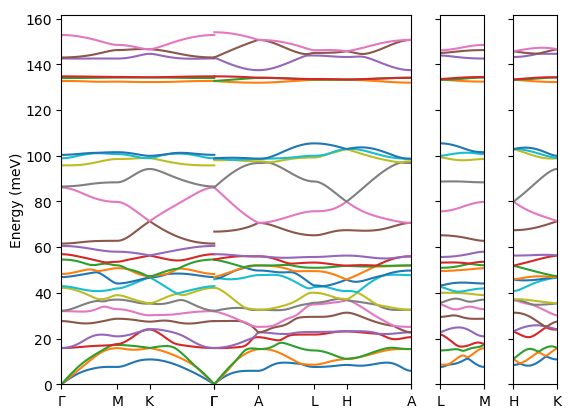

In [6]:
import seekpath
import numpy as np
from euphonic import ForceConstants
from euphonic.plot import plot_1d

fc = ForceConstants.from_castep('euphonic_files/quartz.castep_bin')

cell = fc.crystal.to_spglib_cell()
qpts_path = seekpath.get_explicit_k_path(cell)['explicit_kpoints_rel']

## Alternatively make a path from [0,0,0] to [1,0,0] to [1,1,1], with 50 steps between each segment
def gen_qpath(path):
    qpts = np.vstack((np.linspace(path[0][0], path[1][0], path[-1]),
                      np.linspace(path[0][1], path[1][1], path[-1]),
                      np.linspace(path[0][2], path[1][2], path[-1]))).T
    for ii in range(1, len(path)-2):
        qseg = np.vstack((np.linspace(path[ii][0], path[ii+1][0], path[-1]),
                          np.linspace(path[ii][1], path[ii+1][1], path[-1]),
                          np.linspace(path[ii][2], path[ii+1][2], path[-1]))).T
        qpts = np.vstack((qpts, qseg))
    return qpts
#qpts_path = gen_qpath([[0,0,0], [1,0,0], [1,1,1], 50])


modes = fc.calculate_qpoint_frequencies(qpts_path)
modes_path = fc.calculate_qpoint_frequencies(qpts_path, asr='reciprocal', splitting=True, insert_gamma=True)
disp_path = modes_path.get_dispersion().split()
fig_path = plot_1d(disp_path, y_label=f'Energy ({modes_path.frequencies.units:~P})', y_min=0)

Note that you can use:

```python
import spglib
spacegroup = spglib.get_spacegroup(cell)
print(spacegroup)
```

To get the space group number of the cell, and then go to this webpage https://www.cryst.ehu.es/cryst/get_kvec.html to look up the kvectors

### Plotting INS intensities

We now plot the expected single crystal INS intensities for the quartz data previously loaded.

For this we first recalculate the modes using `calculate_qpoint_phonon_modes` but without including the LO-TO splitting, and then use the `calculate_structure_factor` and `calculate_sqw_map` methods.

We also now need to define the energy bins to rebin the intensities into, and also specify an experimental resolution (energy) broadening.

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xe

C:\Users\User\AppData\Local\Temp\ipykernel_29444\1720770805.py:4: UserWarning: Euphonic's C extension couldn't be imported from C:\Users\User\AppData\Local\mambaforge\envs\ralindia\lib\site-packages\euphonic, it may not have been installed. Falling back to pure Python calculation.
  modes_ins = fc.calculate_qpoint_phonon_modes(qpts_path, asr='reciprocal')


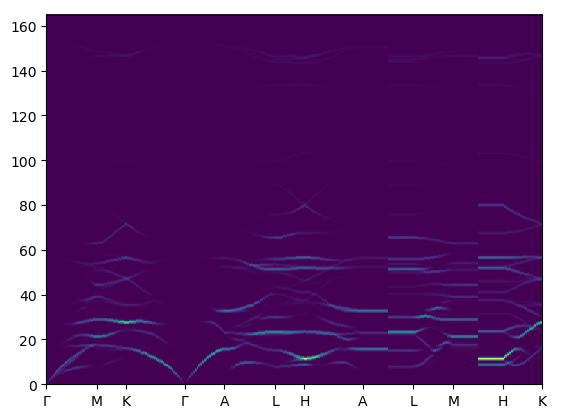

In [7]:
from euphonic import ureg
ebins = np.linspace(0, 165, 500)*ureg('meV')

modes_ins = fc.calculate_qpoint_phonon_modes(qpts_path, asr='reciprocal')
sf = modes_ins.calculate_structure_factor()
sqw = sf.calculate_sqw_map(ebins)
sqw_exp = sqw.broaden(y_width=1*ureg('meV'))

from euphonic.plot import plot_2d
fig = plot_2d(sqw_exp)

## Powder examples

### Density of states

We'll now use Euphonic to calculate the phonon density of states (pDOS) for Aluminium and compare this to measured data.

First we'll load the experimental data (which we had previously calculated using Mantid, but now converted to Euphonic format). Then we'll load the Phonopy calculated force constants for Aluminium, apply some experimental energy broadening and plot the two curves.

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xe

C:\Users\User\AppData\Local\Temp\ipykernel_29444\3988029399.py:10: UserWarning: Euphonic's C extension couldn't be imported from C:\Users\User\AppData\Local\mambaforge\envs\ralindia\lib\site-packages\euphonic, it may not have been installed. Falling back to pure Python calculation.
  modes_al = fc_al.calculate_qpoint_phonon_modes(qpts_al)


Text(0, 0.5, 'pDOS (arb. units)')

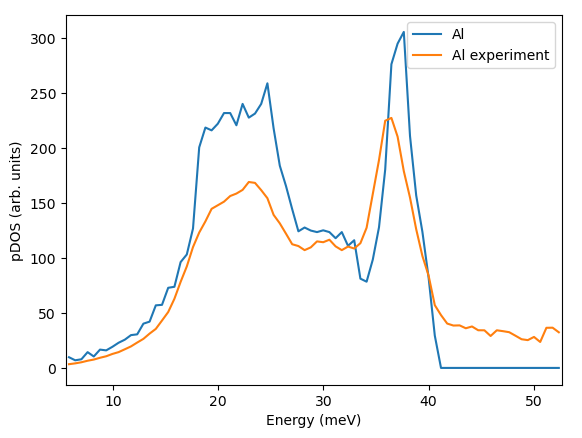

In [8]:
from euphonic import Spectrum1D
from euphonic.plot import plot_1d, plot_1d_to_axis
from euphonic.util import mp_grid

exp_dos_al = Spectrum1D.from_json_file('euphonic_files/Al_experimental_dos.json')

fc_al = ForceConstants.from_phonopy(summary_name='euphonic_files/Al-444-lda.yaml')

qpts_al = mp_grid(fc_al.crystal.get_mp_grid_spec())
modes_al = fc_al.calculate_qpoint_phonon_modes(qpts_al)
ebins_al = exp_dos_al.x_data
pdos_al = modes_al.calculate_pdos(ebins_al, weighting='coherent')
dos_al = pdos_al.sum()
dos_al.metadata['label'] = 'Al'

scale = np.nanmean(dos_al.y_data.magnitude/exp_dos_al.y_data.magnitude)
exp_dos_al.y_data *= scale

fig = plot_1d(dos_al)
ax = fig.get_axes()[0]
plot_1d_to_axis(exp_dos_al, ax)
ax.set_xlabel('Energy (meV)')
ax.set_ylabel('pDOS (arb. units)')

### Plotting ($S(|\mathbf{Q}|, \omega)$)

We'll use Euphonic to calculate the powder averaged INS intensities and plot them side-by-side.

The original data, which we used Mantid to load and plot looks like this:

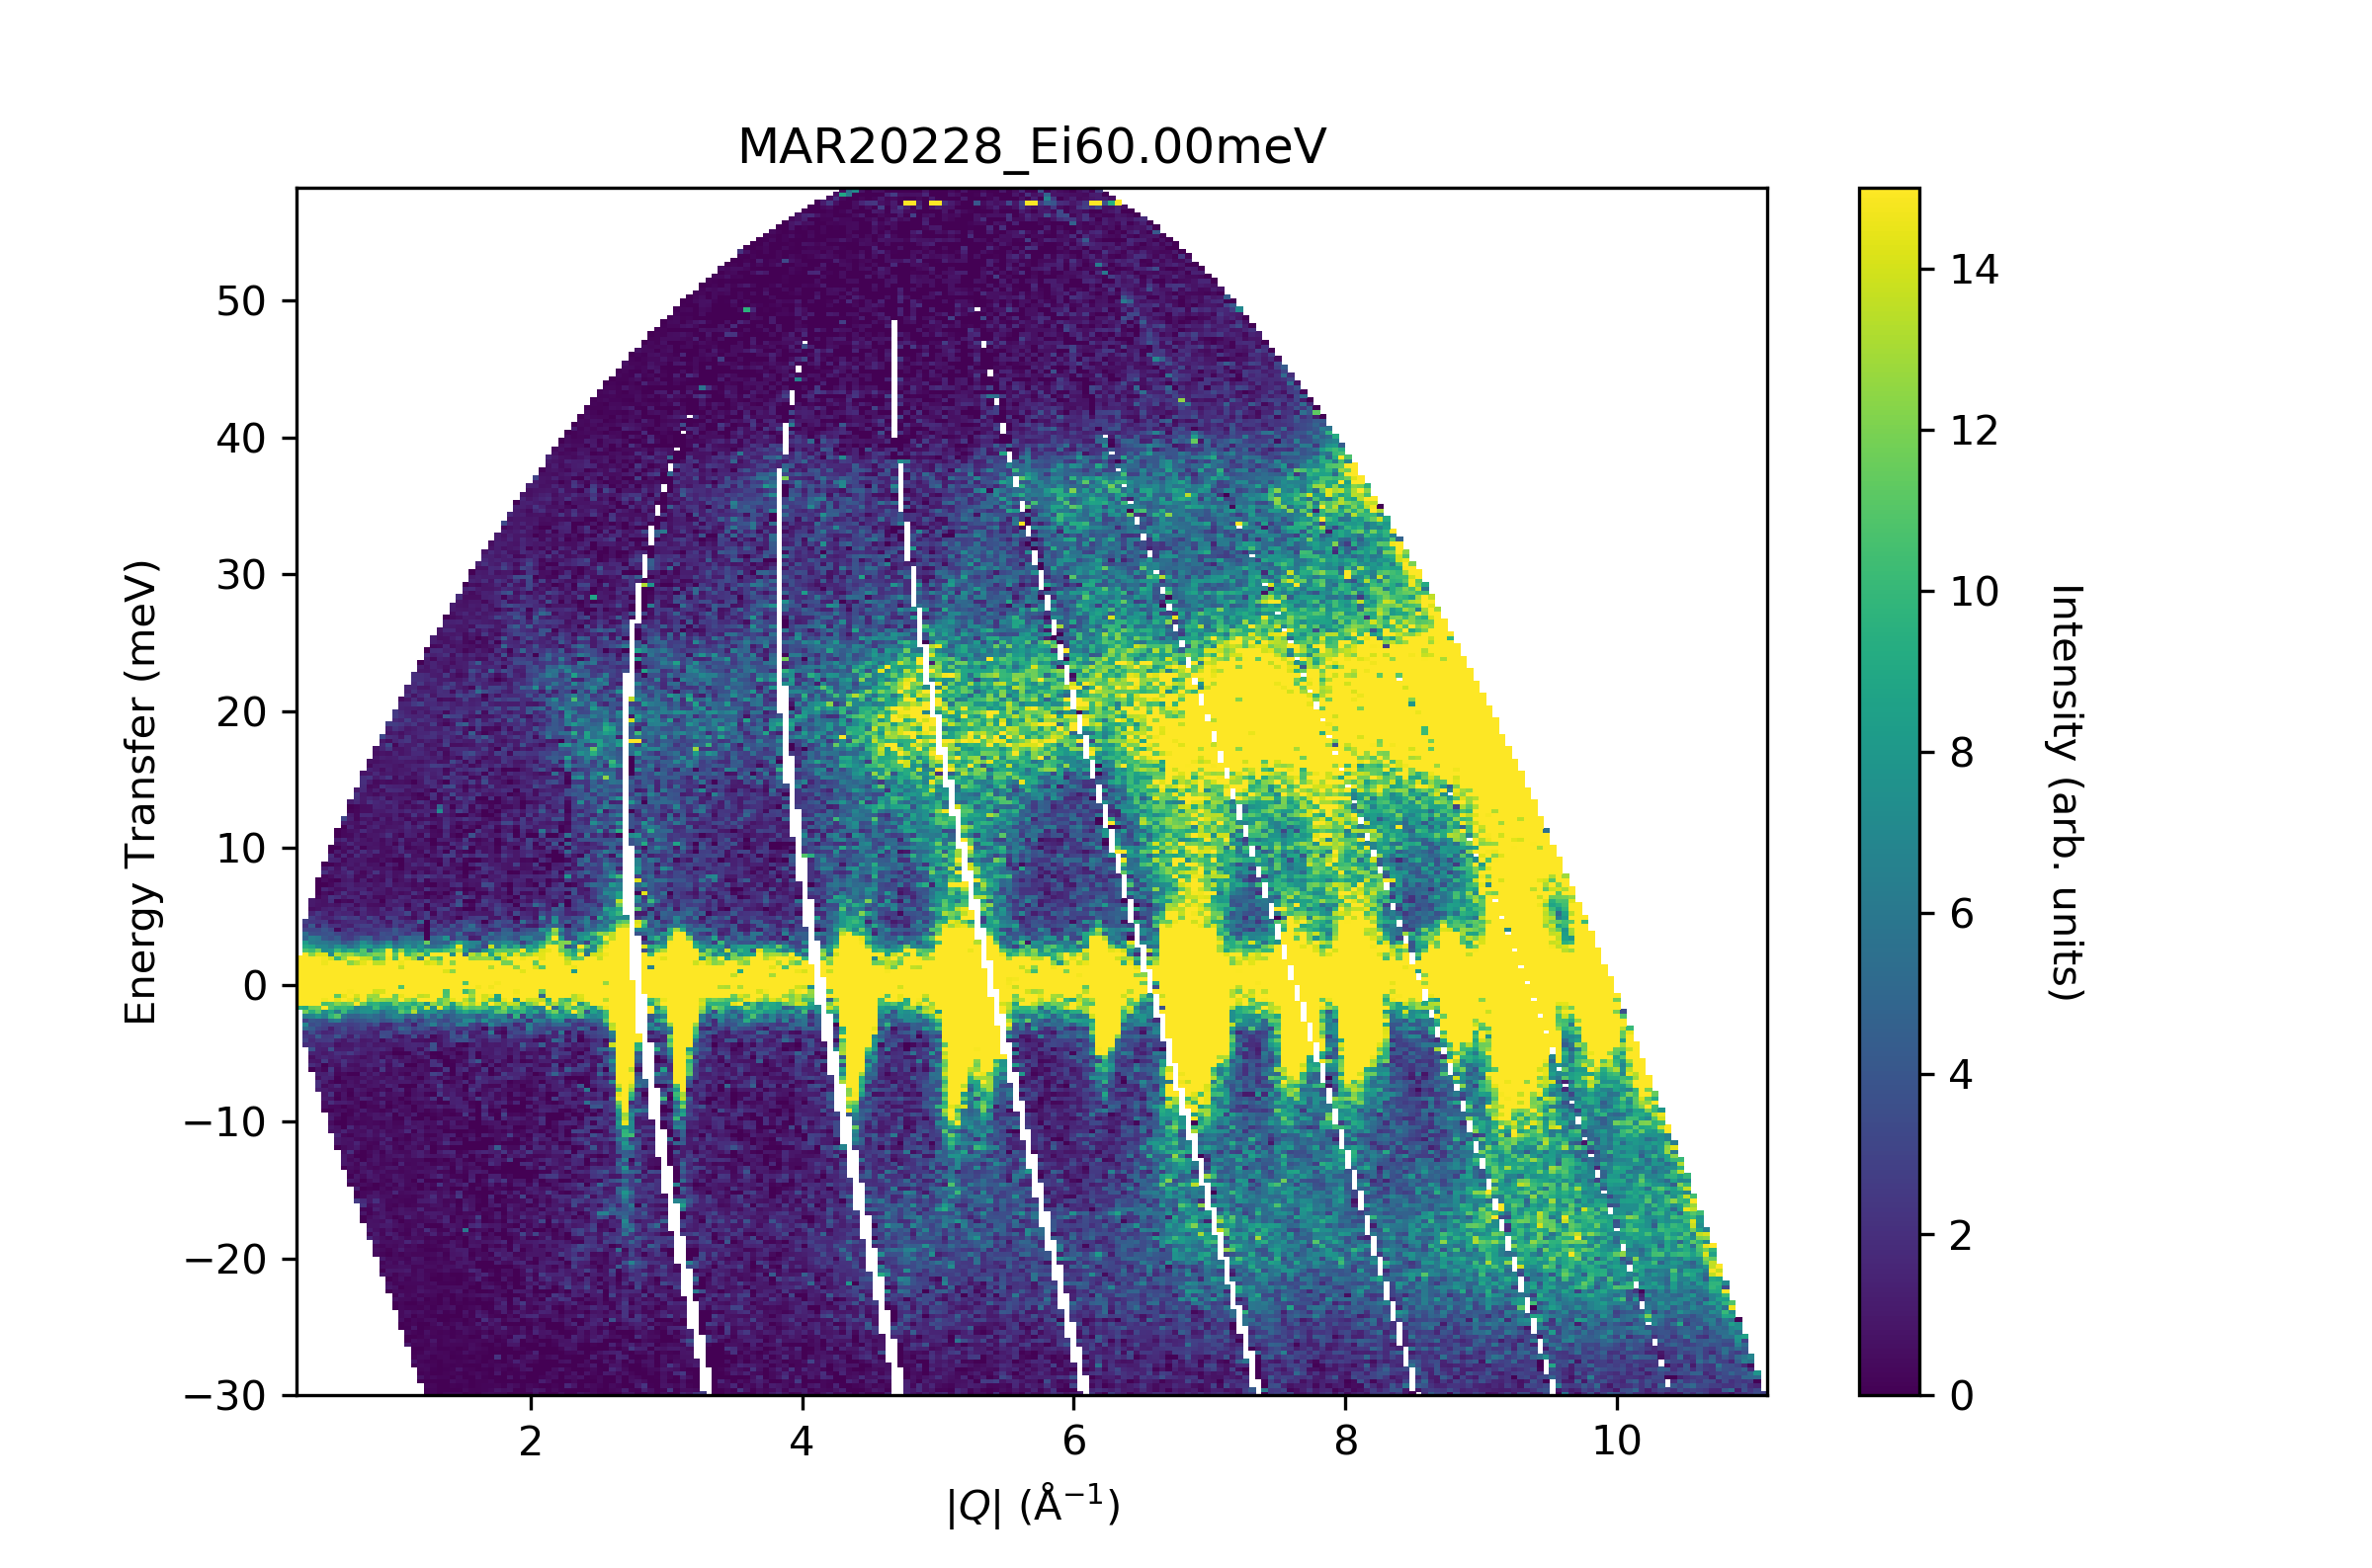

ForceConstants data was loaded
Setting up dimensions...
Sampling 400 |q| shells between 0.0 1/Å and 10.0 1/Å
Final npts: 20000
Plotting figure: max intensity 2.5502211569933957 1/meV


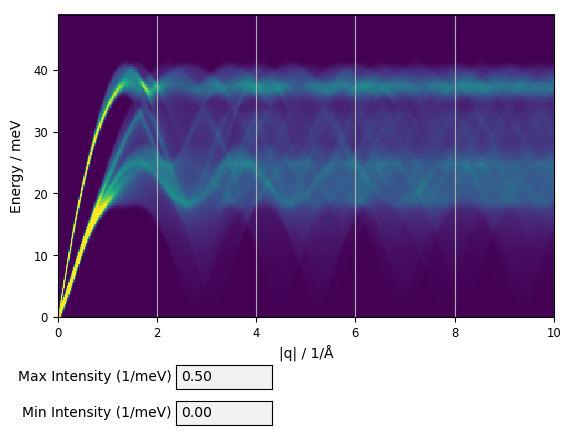

In [9]:
# Note that this calculation can take several minutes
from euphonic.cli.powder_map import main as pmain
pmain(['euphonic_files/Al-444-lda.yaml', '--q-max=10', '--npts-density=1000', '--npts-max=20000', 
       '--eb=1', '--n-threads=30', '--v-max=0.5', '--disable-c'])